In [1]:
# First, let's see what we can import
import sys
import decontx
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt



def create_test_data(n_genes=500, n_cells=200, n_empty=1000, contamination=0.1, seed=42):
    """Create simple synthetic data for testing."""
    np.random.seed(seed)

    # Create true expression for 5 cell types
    n_types = 5
    cells_per_type = n_cells // n_types
    true_counts = np.zeros((n_genes, n_cells))

    # Each cell type expresses different genes
    for cell_type in range(n_types):
        start_cell = cell_type * cells_per_type
        end_cell = min(start_cell + cells_per_type, n_cells)

        # High expression for marker genes
        marker_genes = range(cell_type * 20, (cell_type + 1) * 20)
        for cell in range(start_cell, end_cell):
            true_counts[list(marker_genes), cell] = np.random.poisson(20, 20)
            # Low background
            other_genes = list(set(range(n_genes)) - set(marker_genes))
            true_counts[other_genes, cell] = np.random.poisson(0.5, len(other_genes))

    # Create soup profile (average of all cells)
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / soup_profile.sum()

    # Add contamination
    observed = true_counts.copy()
    for cell in range(n_cells):
        cell_total = true_counts[:, cell].sum()
        contam_counts = np.random.poisson(soup_profile * cell_total * contamination)
        observed[:, cell] += contam_counts

    # Create empty droplets
    empty_counts = np.zeros((n_genes, n_empty))
    for i in range(n_empty):
        n_umis = np.random.poisson(10)  # Low UMI counts
        if n_umis > 0:
            empty_counts[:, i] = np.random.multinomial(n_umis, soup_profile)

    # Combine for raw matrix
    raw = np.hstack([empty_counts, observed])

    return {
        'raw': sp.csr_matrix(raw),
        'filtered': sp.csr_matrix(observed),
        'true': sp.csr_matrix(true_counts),
        'genes': [f"Gene_{i:04d}" for i in range(n_genes)],
        'cells': [f"Cell_{i:04d}" for i in range(n_cells)],
        'contamination': contamination,
        'cell_types': np.repeat(range(n_types), cells_per_type)[:n_cells]
    }

# Create test data
data = create_test_data(n_genes=300, n_cells=100, contamination=0.15, seed=42)
print(f"Created data: {data['raw'].shape[0]} genes, {data['raw'].shape[1]} droplets")
print(f"Filtered: {data['filtered'].shape[1]} cells")
print(f"True contamination: {data['contamination']:.1%}")

C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created data: 300 genes, 1100 droplets
Filtered: 100 cells
True contamination: 15.0%


In [2]:
# Clean imports now
from decontx import decontx, simulate_contamination
import anndata as adata_module
import pandas as pd
import numpy as np


print("✓ Successfully imported decontx functions")

✓ Successfully imported decontx functions


In [3]:
# Create AnnData object from your test data
adata = adata_module.AnnData(
    X=data['filtered'].T,  # AnnData expects cells x genes
    var=pd.DataFrame(index=data['genes']),
    obs=pd.DataFrame(index=data['cells'])
)

# Add cell type info
adata.obs['cell_type'] = data['cell_types']

print(f"Created AnnData: {adata.shape} (cells x genes)")
print(f"Cell types: {adata.obs['cell_type'].unique()}")
print(f"Data type: {type(adata.X)}")

Created AnnData: (100, 300) (cells x genes)
Cell types: [0 1 2 3 4]
Data type: <class 'scipy.sparse._csc.csc_matrix'>


In [4]:
# Very basic decontx test - expect this to break early!
try:
    print("Running basic decontx...")
    
    result = decontx(
        adata, 
        copy=True,
        verbose=True,
        max_iter=5,  # Very short for testing
        seed=42
    )
    
    print("🎉 It worked! (surprising)")
    print(f"Result shape: {result.shape}")
    
except Exception as e:
    print(f"💥 Expected error: {e}")
    
    # Show just the error type and message, not full traceback yet
    import traceback
    print(f"Error type: {type(e).__name__}")
    print("Last few lines of traceback:")
    tb_lines = traceback.format_exc().split('\n')
    for line in tb_lines[-6:]:
        if line.strip():
            print(f"  {line}")



Running basic decontx...
2025-09-04 10:57:51 --------------------------------------------------
2025-09-04 10:57:51 Starting DecontX
2025-09-04 10:57:51 --------------------------------------------------
2025-09-04 10:57:51 .. Generating UMAP and estimating cell types


C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\anndata\_core\anndata.py:633: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\nruff\PycharmProjects\decontx-python\decontx\core.py:268: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_temp.X = X_norm
C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2025-09-04 10:57:59 .... Generated 5 clusters using DBSCAN (eps=1.0)
2025-09-04 10:57:59 .... Using 5 cell clusters
2025-09-04 10:57:59 .. Processing 100 cells and 300 genes
2025-09-04 10:57:59 .... Estimating contamination
2025-09-04 10:58:00 ...... Mean contamination: 25.78%
2025-09-04 10:58:00 ...... Median contamination: 25.75%
2025-09-04 10:58:00 ...... Range: 19.97% - 30.15%
2025-09-04 10:58:00 ...... Cells >50% contaminated: 0
2025-09-04 10:58:00 ...... Converged in 0 likelihood evaluations
2025-09-04 10:58:00 .. Storing results
2025-09-04 10:58:00 .... Stored decontaminated counts in .layers['decontX_counts']
2025-09-04 10:58:00 .... Stored contamination estimates in .obs['decontX_contamination']
2025-09-04 10:58:00 --------------------------------------------------
2025-09-04 10:58:00 Completed DecontX
2025-09-04 10:58:00 --------------------------------------------------
🎉 It worked! (surprising)
Result shape: (100, 300)


In [5]:
# Check the returned result object, not the original adata
print("Results in returned object:")
print(f"Layers: {list(result.layers.keys())}")
print(f"Obs columns: {list(result.obs.columns)}")

# Check for contamination estimates
if 'decontX_contamination' in result.obs:
    print(f"Contamination range: {result.obs['decontX_contamination'].min():.1%} - {result.obs['decontX_contamination'].max():.1%}")
    print(f"Mean contamination: {result.obs['decontX_contamination'].mean():.1%}")

# Check for decontaminated counts
if 'decontX_counts' in result.layers:
    print(f"Decontaminated matrix shape: {result.layers['decontX_counts'].shape}")
    print(f"Original sum: {adata.X.sum():.0f}")
    print(f"Decontaminated sum: {result.layers['decontX_counts'].sum():.0f}")

Results in returned object:
Layers: ['decontX_counts']
Obs columns: ['cell_type', 'decontX_contamination', 'decontX_clusters']
Contamination range: 20.0% - 30.2%
Mean contamination: 25.8%
Decontaminated matrix shape: (100, 300)
Original sum: 62325
Decontaminated sum: 46659


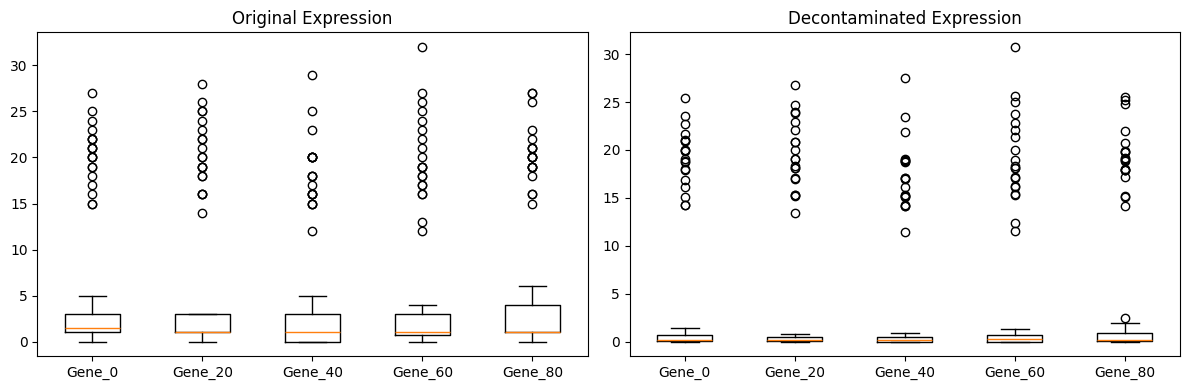

In [6]:
# Let's compare original vs decontaminated
import matplotlib.pyplot as plt

# Check a few marker genes
marker_genes = [f"Gene_{i:04d}" for i in [0, 20, 40, 60, 80]]  # One from each cell type
gene_idx = [result.var_names.get_loc(g) for g in marker_genes if g in result.var_names]

if gene_idx:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original expression
    axes[0].boxplot([result.X[:, i].toarray().flatten() for i in gene_idx])
    axes[0].set_title("Original Expression")
    axes[0].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    # Decontaminated expression  
    axes[1].boxplot([result.layers['decontX_counts'][:, i] for i in gene_idx])
    axes[1].set_title("Decontaminated Expression")
    axes[1].set_xticklabels([f"Gene_{i*20}" for i in range(len(gene_idx))])
    
    plt.tight_layout()
    plt.show()

R callback write-console: Loading required package: SingleCellExperiment
  
R callback write-console: Loading required package: SummarizedExperiment
  
R callback write-console: Loading required package: MatrixGenerics
  
R callback write-console: Loading required package: matrixStats
  
R callback write-console: 
Attaching package: 'MatrixGenerics'

  
R callback write-console: The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCu

🔬 DecontX Python vs R Comparison - DIAGNOSTIC MODE

=== R SETUP ===


R callback write-console: 
Attaching package: 'IRanges'

  
R callback write-console: The following object is masked from 'package:grDevices':

    windows

  
R callback write-console: Loading required package: GenomeInfoDb
  
R callback write-console: Loading required package: Biobase
  
R callback write-console: Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

  
R callback write-console: 
Attaching package: 'Biobase'

  
R callback write-console: The following object is masked from 'package:MatrixGenerics':

    rowMedians

  
R callback write-console: The following objects are masked from 'package:matrixStats':

    anyMissing, rowMedians

  
R callback write-console: Loading required package: scuttle
  
R callback write-console: Loading required package: ggplot2
  
R callback write-console: 
Attaching package: 'dbscan'

  
R callbac

✅ R decontX loaded successfully

=== DATA PREPARATION ===
✅ Created test data: (100, 300) (cells x genes)
   UMI range: 0 - 38
   Total UMIs per cell: [595. 632. 655. 641. 659.]

=== R CLUSTERING DIAGNOSTICS ===
R: Genes before/after zero filter: 300 -> 300 
R: Normalization complete. Range: 0 4.98939 
R: Selected 300 variable genes
R: Filtered matrix dimensions: 300 100 
R: UMAP n_neighbors: 15 
R: UMAP range: -2.073442 2.202016 -2.641548 3.089501 
R: DBSCAN iteration 0 eps = 1 clusters = 2 
R: Final clusters: 2 3 
R: Cluster sizes: 84 16 
R: Normalization range: 0.000 to 4.989
R: UMAP shape: (100, 2)
R: UMAP range: [-2.07, 2.20] x [-2.64, 3.09]
R: Final clusters: [2 3]
R: Cluster sizes: [ 0  0 84 16]

=== PYTHON CLUSTERING DIAGNOSTICS ===
Python: Genes before/after zero filter: 300 -> 300
Python: Lib sizes range: 557 - 708, median: 621
Python: Normalization range: 0.000 to 5.289
Python: Selected 300 variable genes
Python: Filtered matrix shape: (100, 300)
Python: UMAP n_neighbors: 15

C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Python: UMAP range: [-12.65, 22.99] x [-10.30, 13.75]
Python: DBSCAN iteration 0, eps = 1.000, clusters = 5
Python: Unique labels: [0 1 2 3 4]
Python: Final clusters: [1 2 3 4 5]
Python: Cluster sizes: [ 0 20 20 20 20 20]

=== VISUAL COMPARISON ===


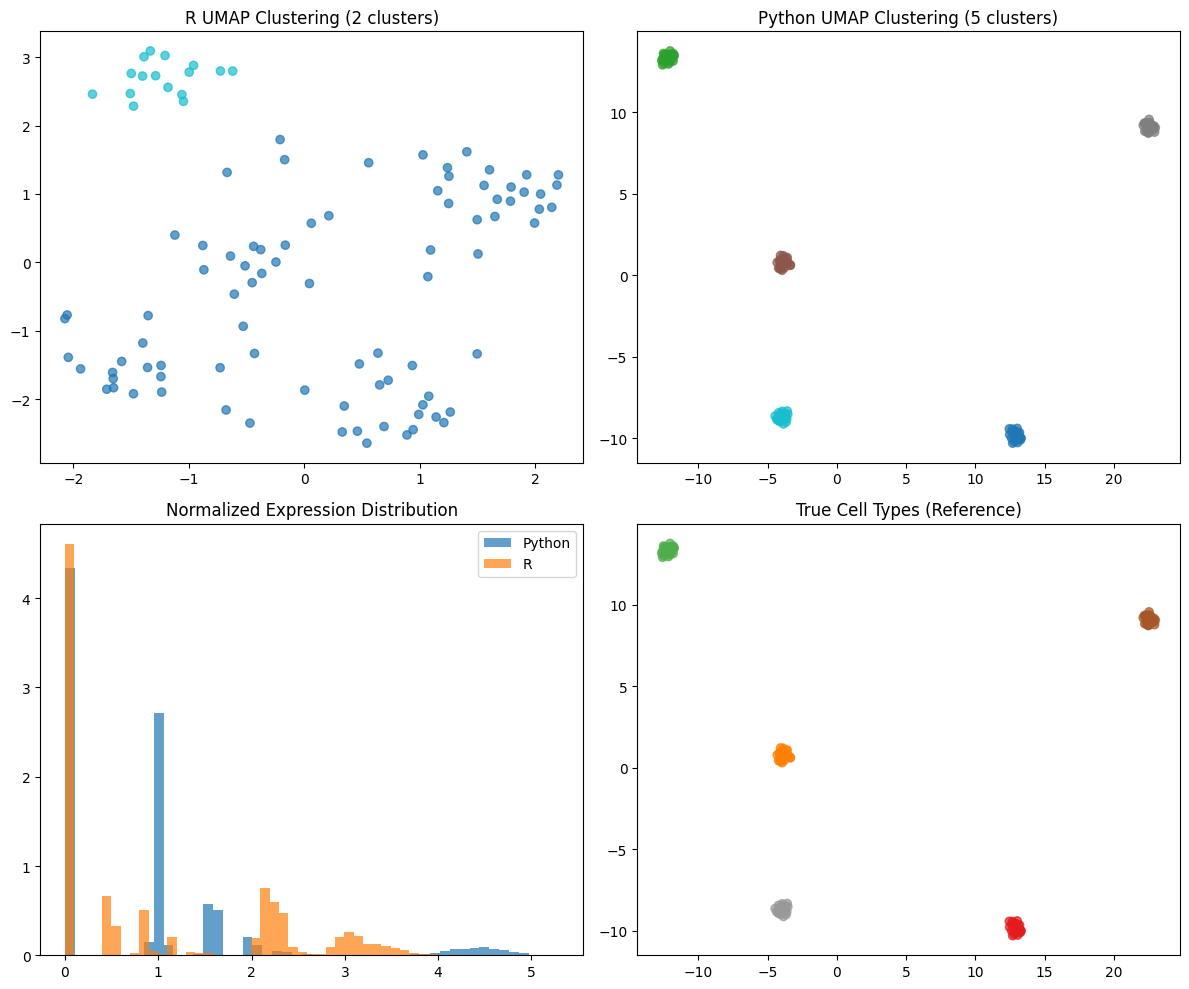


=== RUNNING FULL DECONTX ===
2025-09-04 11:00:18 --------------------------------------------------
2025-09-04 11:00:18 Starting DecontX
2025-09-04 11:00:18 --------------------------------------------------
2025-09-04 11:00:18 .. Generating UMAP and estimating cell types
2025-09-04 11:00:18 .... Generated 5 clusters using DBSCAN (eps=1.0)
2025-09-04 11:00:18 .... Using 5 cell clusters
2025-09-04 11:00:18 .. Processing 100 cells and 300 genes
2025-09-04 11:00:18 .... Estimating contamination


C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\anndata\_core\anndata.py:633: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\nruff\PycharmProjects\decontx-python\decontx\core.py:268: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata_temp.X = X_norm
C:\Users\nruff\PycharmProjects\decontx-python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
R callback write-console: --------------------------------------------------
  
R callback write-console: Starting DecontX
  
R callback write-console: -------------------------------

2025-09-04 11:00:19 ...... Mean contamination: 25.78%
2025-09-04 11:00:19 ...... Median contamination: 25.75%
2025-09-04 11:00:19 ...... Range: 19.97% - 30.15%
2025-09-04 11:00:19 ...... Cells >50% contaminated: 0
2025-09-04 11:00:19 ...... Converged in 0 likelihood evaluations
2025-09-04 11:00:19 .. Storing results
2025-09-04 11:00:19 .... Stored decontaminated counts in .layers['decontX_counts']
2025-09-04 11:00:19 .... Stored contamination estimates in .obs['decontX_contamination']
2025-09-04 11:00:19 --------------------------------------------------
2025-09-04 11:00:19 Completed DecontX
2025-09-04 11:00:19 --------------------------------------------------
✅ Python completed: 5 clusters

=== R DECONTX ===


R callback write-console: Thu Sep  4 11:00:22 2025 .... Estimating contamination
  
R callback write-console: Thu Sep  4 11:00:22 2025 .. Calculating final decontaminated matrix
  
R callback write-console: --------------------------------------------------
  
R callback write-console: Completed DecontX. Total time: 2.420551 secs
  
R callback write-console: --------------------------------------------------
  


✅ R completed: 2 clusters

=== COMPARISON RESULTS ===
True contamination:   15.0%
Python: Mean=25.8%, Std=2.2%, Clusters=5
R:      Mean=15.9%, Std=8.4%, Clusters=2
Correlation: 0.097
Mean Absolute Error: 10.6%

=== DETAILED CLUSTER ANALYSIS ===
Python cluster assignments: (array([1, 2, 3, 4, 5]), array([20, 20, 20, 20, 20]))
R cluster assignments: (array([1., 2.]), array([ 6, 94]))
Adjusted Rand Index (clustering similarity): 0.013
Cells with different cluster assignments: 74/100
Examples of differences:
  Cell 6: Python=1, R=2, True type=0
  Cell 7: Python=1, R=2, True type=0
  Cell 8: Python=1, R=2, True type=0
  Cell 9: Python=1, R=2, True type=0
  Cell 10: Python=1, R=2, True type=0
  Cell 11: Python=1, R=2, True type=0
  Cell 12: Python=1, R=2, True type=0
  Cell 13: Python=1, R=2, True type=0
  Cell 14: Python=1, R=2, True type=0
  Cell 15: Python=1, R=2, True type=0


In [8]:
# Complete Python vs R decontX comparison WITH DIAGNOSTICS
import rpy2.robjects as ro
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as adata_module
from decontx import decontx
import matplotlib.pyplot as plt

print("🔬 DecontX Python vs R Comparison - DIAGNOSTIC MODE")

# 1. Setup R environment
print("\n=== R SETUP ===")
try:
    ro.r('library(decontX)')
    ro.r('library(Matrix)')
    ro.r('library(scater)')
    ro.r('library(SingleCellExperiment)')
    ro.r('library(uwot)')
    ro.r('library(dbscan)')
    print("✅ R decontX loaded successfully")
except Exception as e:
    print(f"❌ Failed to load R packages: {e}")
    exit()

# 2. Create test data
def create_test_data(n_genes=300, n_cells=100, n_empty=1000, contamination=0.15, seed=42):
    np.random.seed(seed)
    n_types = 5
    cells_per_type = n_cells // n_types
    true_counts = np.zeros((n_genes, n_cells))
    
    for cell_type in range(n_types):
        start_cell = cell_type * cells_per_type
        end_cell = min(start_cell + cells_per_type, n_cells)
        marker_genes = range(cell_type * 20, (cell_type + 1) * 20)
        for cell in range(start_cell, end_cell):
            true_counts[list(marker_genes), cell] = np.random.poisson(20, 20)
            other_genes = list(set(range(n_genes)) - set(marker_genes))
            true_counts[other_genes, cell] = np.random.poisson(0.5, len(other_genes))
    
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / soup_profile.sum()
    
    observed = true_counts.copy()
    for cell in range(n_cells):
        cell_total = true_counts[:, cell].sum()
        contam_counts = np.random.poisson(soup_profile * cell_total * contamination)
        observed[:, cell] += contam_counts
    
    return {
        'filtered': sp.csr_matrix(observed),
        'genes': [f"Gene_{i:04d}" for i in range(n_genes)],
        'cells': [f"Cell_{i:04d}" for i in range(n_cells)],
        'contamination': contamination,
        'cell_types': np.repeat(range(n_types), cells_per_type)[:n_cells]
    }

# 3. Prepare data
print("\n=== DATA PREPARATION ===")
data = create_test_data(n_genes=300, n_cells=100, contamination=0.15, seed=42)
adata = adata_module.AnnData(
    X=data['filtered'].T,
    var=pd.DataFrame(index=data['genes']),
    obs=pd.DataFrame(index=data['cells'])
)
adata.obs['cell_type'] = data['cell_types']
print(f"✅ Created test data: {adata.shape} (cells x genes)")
print(f"   UMI range: {adata.X.min():.0f} - {adata.X.max():.0f}")
print(f"   Total UMIs per cell: {np.array(adata.X.sum(axis=1)).flatten()[:5]}")

# 4. DIAGNOSTIC: Step-by-step R clustering 
print("\n=== R CLUSTERING DIAGNOSTICS ===")

# Send data to R
counts_matrix = adata.X.T.toarray().astype(int)
ro.globalenv['py_counts'] = ro.r.matrix(
    ro.FloatVector(counts_matrix.flatten()), 
    nrow=counts_matrix.shape[0], 
    ncol=counts_matrix.shape[1]
)

# Step-by-step R clustering with diagnostics
ro.r('''
# Set seed for reproducibility
set.seed(42)

# Step 1: Create SCE object
sce <- SingleCellExperiment(assays = list(counts = py_counts))

# Step 2: Filter zero genes (like R)
gene_counts <- Matrix::rowSums(counts(sce))
nonzero_genes <- gene_counts > 0
cat("R: Genes before/after zero filter:", nrow(sce), "->", sum(nonzero_genes), "\n")
sce <- sce[nonzero_genes, ]

# Step 3: Log normalization (exact R method)
sce <- scater::logNormCounts(sce, log = TRUE)
cat("R: Normalization complete. Range:", range(logcounts(sce)), "\n")

# Step 4: Variable gene selection
if (nrow(sce) <= 2000) {
    topVariableGenes <- seq_len(nrow(sce))
} else {
    # This is what R actually does - need scran
    library(scran)
    sce.var <- scran::modelGeneVar(sce)
    topVariableGenes <- order(sce.var$bio, decreasing = TRUE)[seq(2000)]
}
cat("R: Selected", length(topVariableGenes), "variable genes\n")

# Step 5: UMAP (exact R method)
countsFiltered <- logcounts(sce)[topVariableGenes, ]
cat("R: Filtered matrix dimensions:", dim(countsFiltered), "\n")

# UMAP with exact parameters
nNeighbors <- min(15, ncol(countsFiltered))
cat("R: UMAP n_neighbors:", nNeighbors, "\n")

resUmap <- uwot::umap(t(as.matrix(countsFiltered)), 
                      n_neighbors = nNeighbors,
                      min_dist = 0.01, 
                      spread = 1,
                      n_components = 2,
                      seed = 42)
                      
cat("R: UMAP range:", apply(resUmap, 2, range), "\n")

# Step 6: DBSCAN clustering 
totalClusters <- 1
dbscanEps <- 1.0
iteration <- 0

while (totalClusters <= 1 && dbscanEps > 0 && iteration < 10) {
    resDbscan <- dbscan::dbscan(resUmap, dbscanEps)
    totalClusters <- length(unique(resDbscan$cluster[resDbscan$cluster != -1]))
    cat("R: DBSCAN iteration", iteration, "eps =", dbscanEps, "clusters =", totalClusters, "\n")
    dbscanEps <- dbscanEps - (0.25 * dbscanEps)
    iteration <- iteration + 1
}

if (totalClusters <= 1) {
    cat("R: Falling back to k-means\n")
    cl <- kmeans(resUmap, 2, nstart = 10)
    z_r <- cl$cluster
} else {
    z_r <- resDbscan$cluster
    # Handle noise points (-1) -> convert to 0 then +1 for 1-indexing
    z_r[z_r == -1] <- 0
    z_r <- z_r + 1
}

cat("R: Final clusters:", unique(z_r), "\n")
cat("R: Cluster sizes:", table(z_r), "\n")

# Store intermediate results for comparison
r_norm_range <- range(logcounts(sce))
r_umap_coords <- resUmap
r_clusters <- z_r
''')

# Get R intermediate results
r_norm_range = ro.r('r_norm_range')
r_umap = np.array(ro.r('r_umap_coords'))
r_clusters_diag = np.array(ro.r('r_clusters')).astype(int)

print(f"R: Normalization range: {r_norm_range[0]:.3f} to {r_norm_range[1]:.3f}")
print(f"R: UMAP shape: {r_umap.shape}")
print(f"R: UMAP range: [{r_umap[:, 0].min():.2f}, {r_umap[:, 0].max():.2f}] x [{r_umap[:, 1].min():.2f}, {r_umap[:, 1].max():.2f}]")
print(f"R: Final clusters: {np.unique(r_clusters_diag)}")
print(f"R: Cluster sizes: {np.bincount(r_clusters_diag)}")

# 5. DIAGNOSTIC: Step-by-step Python clustering
print("\n=== PYTHON CLUSTERING DIAGNOSTICS ===")

def diagnose_python_clustering(adata, var_genes=2000, seed=42):
    import scanpy as sc
    from scipy.sparse import issparse
    from sklearn.decomposition import PCA
    import umap
    from sklearn.cluster import DBSCAN, KMeans
    
    # Step 1: Copy and filter
    adata_temp = adata.copy()
    gene_counts = np.array(adata_temp.X.sum(axis=0)).flatten()
    nonzero_genes = gene_counts > 0
    print(f"Python: Genes before/after zero filter: {adata_temp.n_vars} -> {sum(nonzero_genes)}")
    adata_temp = adata_temp[:, nonzero_genes]
    
    # Step 2: Normalization - try to match R exactly
    lib_sizes = np.array(adata_temp.X.sum(axis=1)).flatten()
    median_lib_size = np.median(lib_sizes)
    
    X_norm = adata_temp.X.copy()
    if issparse(X_norm):
        X_norm = X_norm.toarray()
    
    print(f"Python: Lib sizes range: {lib_sizes.min():.0f} - {lib_sizes.max():.0f}, median: {median_lib_size:.0f}")
    
    # Try R's exact normalization: log2((counts/lib_size) * median_lib_size + 1)
    for i in range(adata_temp.n_obs):
        X_norm[i, :] = np.log2((X_norm[i, :] / lib_sizes[i]) * median_lib_size + 1)
    
    print(f"Python: Normalization range: {X_norm.min():.3f} to {X_norm.max():.3f}")
    
    # Step 3: Variable gene selection - simplified
    if adata_temp.n_vars <= var_genes:
        top_var_genes = np.arange(adata_temp.n_vars)
    else:
        # Simple variance-based selection
        gene_vars = np.var(X_norm, axis=0)
        top_var_genes = np.argsort(gene_vars)[::-1][:var_genes]
    
    print(f"Python: Selected {len(top_var_genes)} variable genes")
    
    counts_filtered = X_norm[:, top_var_genes]
    print(f"Python: Filtered matrix shape: {counts_filtered.shape}")
    
    # Step 4: PCA
    n_pcs = min(50, counts_filtered.shape[1], counts_filtered.shape[0] - 1)
    pca = PCA(n_components=n_pcs, random_state=seed)
    pca_coords = pca.fit_transform(counts_filtered)
    
    # Step 5: UMAP
    n_neighbors = min(15, counts_filtered.shape[0] - 1)
    print(f"Python: UMAP n_neighbors: {n_neighbors}")
    
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=0.01,
        spread=1.0,
        n_components=2,
        random_state=seed,
        metric='euclidean'
    )
    umap_coords = reducer.fit_transform(pca_coords)
    
    print(f"Python: UMAP range: [{umap_coords[:, 0].min():.2f}, {umap_coords[:, 0].max():.2f}] x [{umap_coords[:, 1].min():.2f}, {umap_coords[:, 1].max():.2f}]")
    
    # Step 6: DBSCAN clustering 
    total_clusters = 1
    eps = 1.0
    iteration = 0
    max_iterations = 10
    
    while total_clusters <= 1 and eps > 0 and iteration < max_iterations:
        clusterer = DBSCAN(eps=eps, min_samples=5)
        cluster_labels = clusterer.fit_predict(umap_coords)
        
        unique_labels = np.unique(cluster_labels)
        non_noise_labels = unique_labels[unique_labels >= 0]
        total_clusters = len(non_noise_labels)
        
        print(f"Python: DBSCAN iteration {iteration}, eps = {eps:.3f}, clusters = {total_clusters}")
        print(f"Python: Unique labels: {unique_labels}")
        
        eps = eps - (0.25 * eps)
        iteration += 1
    
    if total_clusters <= 1:
        print("Python: Falling back to k-means")
        kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10)
        cluster_labels = kmeans.fit_predict(umap_coords)
        total_clusters = 2
    
    # Convert to 1-indexed
    if -1 in cluster_labels:
        cluster_labels[cluster_labels == -1] = 0
    z_labels = cluster_labels + 1
    
    print(f"Python: Final clusters: {np.unique(z_labels)}")
    print(f"Python: Cluster sizes: {np.bincount(z_labels)}")
    
    return z_labels, umap_coords, X_norm

py_clusters, py_umap, py_norm = diagnose_python_clustering(adata, var_genes=2000, seed=42)

# 6. VISUAL COMPARISON
print("\n=== VISUAL COMPARISON ===")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# R UMAP
axes[0,0].scatter(r_umap[:, 0], r_umap[:, 1], c=r_clusters_diag, cmap='tab10', alpha=0.7)
axes[0,0].set_title(f'R UMAP Clustering ({len(np.unique(r_clusters_diag))} clusters)')

# Python UMAP  
axes[0,1].scatter(py_umap[:, 0], py_umap[:, 1], c=py_clusters, cmap='tab10', alpha=0.7)
axes[0,1].set_title(f'Python UMAP Clustering ({len(np.unique(py_clusters))} clusters)')

# Normalization comparison
axes[1,0].hist(py_norm.flatten(), bins=50, alpha=0.7, label='Python', density=True)
# We need to get R normalized data
ro.r('py_r_norm <- as.vector(logcounts(sce))')
r_norm_values = np.array(ro.r('py_r_norm'))
axes[1,0].hist(r_norm_values, bins=50, alpha=0.7, label='R', density=True)
axes[1,0].set_title('Normalized Expression Distribution')
axes[1,0].legend()

# True cell types for reference
axes[1,1].scatter(py_umap[:, 0], py_umap[:, 1], c=data['cell_types'], cmap='Set1', alpha=0.7)
axes[1,1].set_title('True Cell Types (Reference)')

plt.tight_layout()
plt.savefig('decontx_clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 7. Run full decontX with diagnostics
print("\n=== RUNNING FULL DECONTX ===")

# Python decontX
python_result = decontx(adata, copy=True, verbose=True, max_iter=5, seed=42, var_genes=2000)
print(f"✅ Python completed: {len(np.unique(python_result.obs['decontX_clusters']))} clusters")

# R decontX
def run_r_decontx(adata):
    counts_matrix = adata.X.T.toarray().astype(int)
    ro.globalenv['counts_data'] = ro.r.matrix(
        ro.FloatVector(counts_matrix.flatten()), 
        nrow=counts_matrix.shape[0], 
        ncol=counts_matrix.shape[1]
    )
    
    ro.r('''
    set.seed(42)
    r_result <- decontX(x = counts_data, z = NULL, maxIter = 5, seed = 42, verbose = TRUE)
    ''')
    
    return {
        'contamination': np.array(ro.r('as.numeric(r_result$contamination)')),
        'clusters': np.array(ro.r('as.numeric(r_result$z)'))
    }

print("\n=== R DECONTX ===")
r_results = run_r_decontx(adata)
print(f"✅ R completed: {len(np.unique(r_results['clusters']))} clusters")

# 8. Final comparison
print("\n=== COMPARISON RESULTS ===")
py_contam = python_result.obs['decontX_contamination'].values
r_contam = r_results['contamination']

print(f"True contamination:   {data['contamination']:.1%}")
print(f"Python: Mean={py_contam.mean():.1%}, Std={py_contam.std():.1%}, Clusters={len(np.unique(python_result.obs['decontX_clusters']))}")
print(f"R:      Mean={r_contam.mean():.1%}, Std={r_contam.std():.1%}, Clusters={len(np.unique(r_results['clusters']))}")

correlation = np.corrcoef(py_contam, r_contam)[0, 1]
mae = np.mean(np.abs(py_contam - r_contam))
print(f"Correlation: {correlation:.3f}")
print(f"Mean Absolute Error: {mae:.1%}")

# 9. Detailed cluster comparison
print("\n=== DETAILED CLUSTER ANALYSIS ===")
print("Python cluster assignments:", np.unique(python_result.obs['decontX_clusters'].values, return_counts=True))
print("R cluster assignments:", np.unique(r_results['clusters'], return_counts=True))

# Cross-tabulation
from sklearn.metrics import adjusted_rand_score
py_clust = python_result.obs['decontX_clusters'].values.astype(int)
r_clust = r_results['clusters'].astype(int)

print(f"Adjusted Rand Index (clustering similarity): {adjusted_rand_score(py_clust, r_clust):.3f}")

# Show which cells are in different clusters
diff_mask = py_clust != r_clust
print(f"Cells with different cluster assignments: {diff_mask.sum()}/{len(diff_mask)}")

if diff_mask.sum() > 0:
    print("Examples of differences:")
    for i in np.where(diff_mask)[0][:10]:  # Show first 10 differences
        print(f"  Cell {i}: Python={py_clust[i]}, R={r_clust[i]}, True type={data['cell_types'][i]}")